# Process output of SA numerics

In [108]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import pandas as pd
import matplotlib as mpl

# Use LaTeX to render all text
mpl.rcParams['text.usetex']     = True
# Use serif (Computer Modern) as the default font family
mpl.rcParams['font.family']     = 'serif'
mpl.rcParams['font.serif']      = ['Computer Modern Roman']
# Optionally, ensure math text uses the same font
mpl.rcParams['mathtext.fontset'] = 'cm'

In [109]:
"""Read in the hDQI+BP data"""
df_bp = pd.read_csv("../data_hdqi/Stephen_in/gibbs_data.csv")     
for col in ("m", "n", "k"):
    df_bp[col] = df_bp[col].astype(int)
print(df_bp.head())

     n     m  k   e     ratio  semicircle
0  100  1000  3   5  0.005000    0.570534
1  100  1000  4   5  0.005000    0.570534
2  100  1000  5   6  0.006000    0.577227
3  100  1000  6   6  0.006000    0.577227
4  100   300  3  10  0.033333    0.679505


In [110]:
"""Read in the SA data"""
# Regex to capture TYPE, m, n, k
ROOT = '../data_hdqi/Stephen_out/my_data_1/'
pattern = re.compile(r'SAStephen_TYPE(?P<type>[^_]+)_m(?P<m>\d+)n(?P<n>\d+)k(?P<k>\d+)_\d+\.npy$')

rows = []
for fname in os.listdir(ROOT):
    match = pattern.match(fname)
    if not match:
        continue
    params = match.groupdict()
    # convert numeric strings to int
    params['n'] = int(params['n'])
    params['m'] = int(params['m'])
    params['k'] = int(params['k'])
    # load the vector
    vec = np.load(os.path.join(ROOT, fname))
    params['mean'] = vec.mean()
    params['std']  = vec.std()
    rows.append(params)
df_sa = pd.DataFrame(rows, columns=['type','n','m','k','mean','std'])

ROOT = '../data_hdqi/Stephen_out/'
pattern = re.compile(r'SAStephen_TYPE(?P<type>[^_]+)_m(?P<m>\d+)n(?P<n>\d+)k(?P<k>\d+)_\d+_(?P<run>\d+)\d+\.npy$')

rows = []
for fname in os.listdir(ROOT):
    match = pattern.match(fname)
    if not match:
        continue
    params = match.groupdict()
    # convert numeric strings to int
    params['n'] = int(params['n'])
    params['m'] = int(params['m'])
    params['k'] = int(params['k'])
    params['run'] = int(params['run'])
    # load the vector
    vec = np.load(os.path.join(ROOT, fname))
    # compute statistics
    rows.append(params)
df_temp = pd.DataFrame(rows, columns=['type','n','m','k','run'])
df_temp = (
        df_temp.groupby(['type', 'n', 'm', 'k'])['run']
          .agg(mean='mean', std='std')
          .reset_index()
    )

# build DataFrame
df_sa.sort_values(['type','n','m','k'], inplace=True)
df_sa.reset_index(drop=True, inplace=True)

df_sa = pd.concat([df_sa, df_temp], ignore_index=True)
print(df_sa)
# df_sa[(df_sa['k'] == 4) & (df_sa['m'] == 2000) & (df_sa['n'] == 200)]


   type    n     m  k      mean       std
0     1  100   300  3  0.717333  0.019539
1     1  100   300  4  0.695000  0.016003
2     1  100   300  5  0.682333  0.013667
3     1  100   300  6  0.674667  0.017461
4     1  100   600  3  0.658167  0.015854
..  ...  ...   ... ..       ...       ...
91    2  800  4800  6  0.578667  0.003581
92    2  800  8000  3  0.601000  0.000898
93    2  800  8000  4  0.576725  0.003168
94    2  800  8000  5  0.568925  0.002183
95    2  800  8000  6  0.562250  0.003245

[96 rows x 6 columns]


/var/folders/h_/l1wrzqpn7g953jxhww7ln1wc0000gq/T/ipykernel_72491/511026293.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_sa = pd.concat([df_sa, df_temp], ignore_index=True)


In [111]:
def plot_combined(df1, df2, r, fix_k=False, k_fix=3):
    """
    df1: DataFrame with columns ['n','m','k','semicircle']
    df2: DataFrame with columns ['type','n','m','k','mean','std']
    r : integer ratio m//n to filter on
    """
    plt.rc("font", size=14)
    # determine all k’s so we can assign them consistent colors
    ks = sorted(set(df1['k']) | set(df2['k']))
    cmap = plt.get_cmap('tab10')
    color_map = {k: cmap(i % cmap.N) for i, k in enumerate(ks)}

    fig, ax = plt.subplots()
    min_y = 1
    max_y = 0

    # 1) semicircle (hDQI) → circle marker + solid line
    for k in ks:
        if fix_k and k_fix != k:
            continue
        sub = df1[(df1['k'] == k) & (df1['m'] // df1['n'] == r)]
        if sub.empty: 
            print(f"[k={k}] hDQI+BP has no data.")
            continue
        ax.scatter(sub['n'], sub['semicircle'],
                   marker='o',
                   color=color_map[k],
                   label=f'k={k}')
        ax.plot(sub['n'], sub['semicircle'],
                linestyle='-',
                color=color_map[k],
                linewidth=0.8)
        min_y = min(sub['semicircle'].min(), min_y)
        max_y = max(sub['semicircle'].max(), max_y)

    # 2) type=1 (SA1) → square marker + dotted line + error bars
    for k in ks:
        if fix_k and k_fix != k:
            continue
        sub = df2[(df2['type'] == '1') & (df2['k'] == k) & (df2['m'] // df2['n'] == r)]
        if sub.empty:
            print(f"[k={k}] SA Type 1 has no data.")
            continue
        ax.errorbar(sub['n'], sub['mean'],
                    yerr=sub['std'],
                    fmt='s',
                    linestyle=':',
                    linewidth=0.8,
                    capsize=4,
                    color=color_map[k])
        min_y = min(sub['mean'].min(), min_y)
        max_y = max(sub['mean'].max(), max_y)

    # 3) type=2 (SA2) → triangle marker + dash‑dot line
    for k in ks:
        if fix_k and k_fix != k:
            continue
        sub = df2[(df2['type'] == '2') &
                (df2['k'] == k) &
                (df2['m'] // df2['n'] == r)]
        if sub.empty:
            continue

        ax.errorbar(sub['n'], sub['mean'],
                    yerr=sub['std'],
                    fmt='^',            # triangle marker
                    linestyle='-.',     # dash‑dot connecting line
                    linewidth=0.8,
                    capsize=4,          # horizontal caps on the error bars
                    elinewidth=1,       # thickness of the error‑bar stems
                    color=color_map[k])
        min_y = min(sub['mean'].min(), min_y)
        max_y = max(sub['mean'].max(), max_y)

    # axis labels and limits
    ax.set_xlabel(r'$n$')
    ax.set_ylabel(f'Approximation ratio $\\langle s \\rangle / m$')
    max_y = min(max_y, 0.95)
    ax.set_ylim(min_y - 0.1, max_y + 0.05)

    # 1st legend: color ↔ k
    leg1 = ax.legend(loc='lower left')

    # 2nd legend: marker ↔ method name
    from matplotlib.lines import Line2D
    proxy_shapes = [
        Line2D([0], [0], marker='o', color='black', linestyle='-', label='hDQI'),
        Line2D([0], [0], marker='s', color='black', linestyle=':', label='SA flips'),
        Line2D([0], [0], marker='^', color='black', linestyle='-.', label='SA Paulis'),
    ]
    ax.add_artist(leg1)
    ax.legend(handles=proxy_shapes, loc='lower right')
    plt.title(rf"Accuracy comparison ($m/n = {r}$)")
    plt.tight_layout()
    if fix_k:
        plt.savefig(f"plots/ratio_{r}_fix{k_fix}.png")
    else:
        plt.savefig(f"plots/ratio_{r}.png")

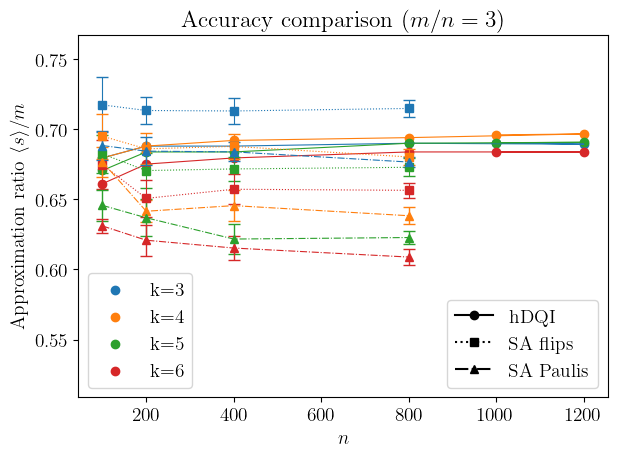

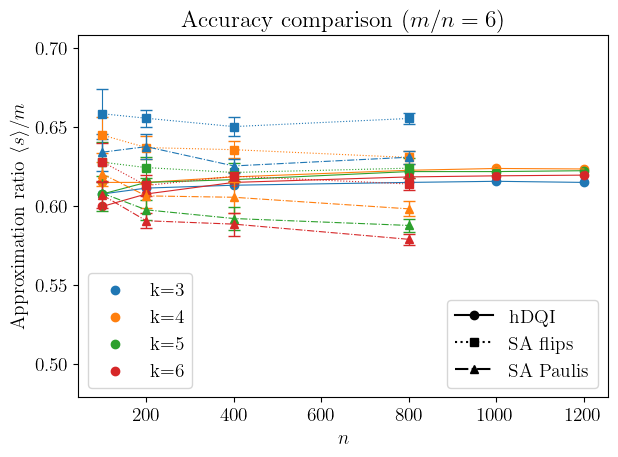

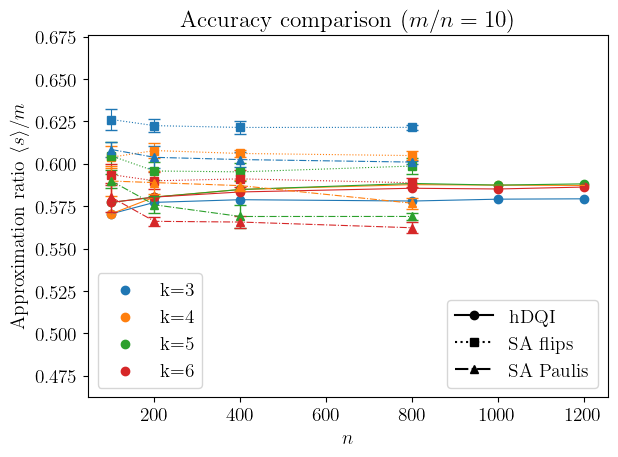

In [112]:
FIX = False
FIX_AT = 6
plot_combined(df_bp, df_sa, 3, fix_k=FIX, k_fix=FIX_AT)
plot_combined(df_bp, df_sa, 6, fix_k=FIX, k_fix=FIX_AT)
plot_combined(df_bp, df_sa, 10, fix_k=FIX, k_fix=FIX_AT)